## <span style=" font-family: Palatino Linotype;"><h1><center><u>HOUSE PRICES PREDICTIONS</u></center></h1></span>                                    

In this Notebook we are trying to predict the sales price for a set of houses with many data each one.<br>
In order to improve the work done here, anyone is invited to post any question of process, methods, decissions that are not understood. Also, anyone can suggest ways to improve the performance of the notebook, because at the end this notebook is not perfect and nobody is an expert, ever...

In order to predict the `SalePrice` we will do some improvements over our Dataset. First, after importing the necessary libraries for the use of important commands, methods, functions in this notebook, is time to have a look at the data we deal with. This step consists on an `exploration` of the Dataset.<br>

After this, the next part of the notebook we will see is from my point of view, one of the most important of all, the `Feature Engineering`. It is important because all the modifications we do ( in case we need it), will affect on the final result of our predictions. Why that? Because, when we import a dataset, not always we are going to have a perfect, clean one. Here we will find `Outliers`, `Missing Data`, `Skewed variables`, `variables with wrong type`,etc.<br>

The next steps will be more related to the construction of the models in order to see which one is the best or if we can try stacking different `weak models` in one.

The House Prices competition final predictions of each Id in the test set are measured with the  Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.) This metric is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed.  RMSLE is pretended to be used when you don't want to penalize huge differences between the predicted and the actual values, when they are high numbers.

Now let's go straight to the point. We are facing a problem of predicting a continuous variable `SalePrice`. This means that we are facing a `Regression`problem. In this kind of problems, we can use an amount of different steps, but the main I will use are structured in the next index.<br><br>


###  <span style=" font-family: Palatino Linotype;"><h3><u>Index</u></h3></span>  
#### [1. Import Libraries and Data](#ImportLibraries)
#### [2. Exploratory Data  Analysis](#EDA)
#### [3. Feature Engineering](#Feature)
- [3.1 Missing Values](#Missing)
- [3.2 Fix Types](#Types)
- [3.3 Correlated variables](#Correlated)
- [3.4 Numerical variables](#Numerical)
- [3.5 Categorical variables](#Categorical)

#### [4. Modelling & Validation](#Modelling)
- [4.1 Basic Models](#Basic)
    - [4.1.1 Support Vector Rregressor](#svr)
    - [4.1.2 Ridge](#ridge)
    - [4.1.3 Lasso](#lasso)
    - [4.1.4 Elastic Net](#elnet)
- [4.2 Ensemble Models](#ensemble)
    - [4.2.1 Stacking Ensemle](#stacking)
    - [4.2.2 Gradient Boosting](#gtb)
        - [4.2.2.1 XGBoost](#xgb)
        - [4.2.2.2 LightGBM](#lgbm)
        - [4.2.2.3 Gradient Boost Regressor](#gbr)

#### [5. Predictions](#Predictions)<br>



<br>
<br>

<a id='ImportLibraries'></a>
### <span style=" font-family: Palatino Linotype;"><h2><center><u>1. IMPORT LIBRARIES AND DATA</u></center></h2></span>                                    

First, we import the necessary libraries...

In [1]:
import numpy as np
from numpy import *
import pandas as pd   
import seaborn as sns #Nice way to show your images
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew #Normalize the  skewness
from sklearn.preprocessing import RobustScaler  #Scaling before pipeline
from scipy.stats import pearsonr
from scipy.stats import norm # for skewness ( not used)
from scipy.special import boxcox1p # for negative skewness
from sklearn.metrics import mean_squared_log_error #metric to evaluate predictions
from sklearn.model_selection import KFold, cross_val_score


#Regressors
from sklearn.pipeline import make_pipeline # transforming steps pipeline
from sklearn.svm import SVR
%pip install xgboost
%pip install lightgbm
import xgboost
import lightgbm as lgbm
from xgboost import plot_importance
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.linear_model import Lasso,LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor # For calculating VIF

On the next step we load the train dataset in `df_train`and the test one in `df_test`. Its also useful to save the `ID` column of the `test`in order to at the end, predict the values of the test. But as we can see, we don't delete the column because in case we would have to drop any row from our test dataset, then the `ID` column would fit the dataset.

In [2]:
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
test_ID = df_test['Id']

<br>
<br>

<a id='EDA'></a>
### <span style=" font-family: Palatino Linotype;"><h2><center><u> 2. EXPLORATORY DATA ANALYSIS</u></center></h2></span>

 First view of the raw dataset: 

In [3]:
df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


With this view we know that:

- We have many variables, categorical and numerical. Besides, we already know because of the *data_description*  file, the kind of variable. The column `Id` won't be there at the end of the Feature Engineering, because it is an identification column which gives us no information and has cero predictive power.<br>  
- There are many missing values, for example in `Alley`, `PoolQC` or `MiscFeature`. In this cases we must think the way to solve it, filling this missing values with the *mode*, *median*, *mean* or just deleting this rows or the whole column.<br>


The types are already assigned to the variables, but sometimes they are not fitting the best one... We will just have a first look to the types but won't change anything.<br>
The problem with the types is that, sometimes, making numeric comparisions between *string-category* and a *float* (for example) is not a good idea.

In [4]:
df_train.info(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

At first one important thing is to see the correlation between the features and the target or just between the features. With this procedure, we can see how strong or weak are the relations between variables . We can do this by using a correlation matrix. The colors show the strenght of the corrrelation  using `Pearson`method from `Pandas`. This Pearson method gives us back the `standard correlation coefficient`:


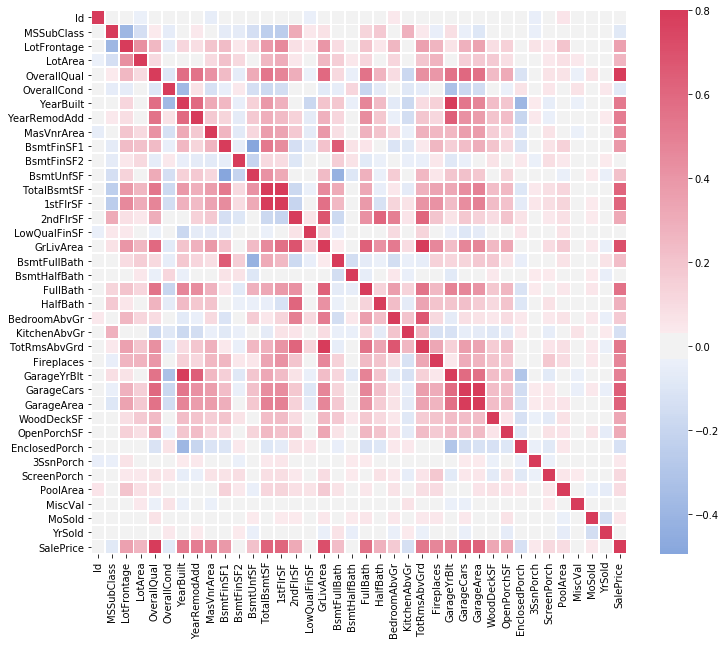

In [5]:
corr_matrix= df_train.corr()
f, ax = plt.subplots(figsize=(12,10))
cmap = sns.diverging_palette(255, 5,as_cmap=True)
sns.heatmap(corr_matrix,cmap=cmap,vmax=0.8,center=0, linewidths=.9)

So, now we can see some notable relations between the variables and the target. For example: `OverallQual`shows a really strong relation with the target.<br>
Also `GarageCars`,`GarageArea`,`GrLivArea` are good predictors for `SalePrice`.

In [6]:
strong_rel = ['TotalBsmtSF','GarageCars','GarageArea','GrLivArea','OverallQual','1stFlrSF']
for var in strong_rel:
    corr, _ = pearsonr(df_train[var], df_train['SalePrice'])
    print(var + "--> type:"+ str(df_train[var].dtypes)  + "; Pearson_corr_value:" + str(round(corr, 2)) + "; Unique values:" + str(len(df_train[var].unique())))

TotalBsmtSF--> type:int64; Pearson_corr_value:0.61; Unique values:721
GarageCars--> type:int64; Pearson_corr_value:0.64; Unique values:5
GarageArea--> type:int64; Pearson_corr_value:0.62; Unique values:441
GrLivArea--> type:int64; Pearson_corr_value:0.71; Unique values:861
OverallQual--> type:int64; Pearson_corr_value:0.79; Unique values:10
1stFlrSF--> type:int64; Pearson_corr_value:0.61; Unique values:753


Conclusions of  4 variables that best affect the `SalePrice`:
- `GarageCars` is a numerical discrete variable it contains the number of cars from 1 to 5. Obviously a house with a garage space for 5 cars, should a bit expensive..
- `GarageArea` is a numerical discrete variable containing the square meters of the garage. It's obvious that there should be a relation between `GarageCars` and `GarageArea`, because with more cars in a Garage, more space you need.
- `GrLivArea`  is a numerical discrete variable containing the ground square meters of the house and so its a powerfull variable for us.
- `OverallQual`is a numerical discrete variable (from 1 to 10) that tells the quality of the overall so, this can be a big pilar for us.

In [7]:
corr, _ = pearsonr(df_train['GarageCars'], df_train['GarageArea'])
print('Pearson coefficient between GarageCars and GarageArea :' +str(corr))

Pearson coefficient between GarageCars and GarageArea :0.8824754142814624


Has we predicted, the correlation between both Garage variables is really high, we can see this relation properly in next steps and decide what to do with them.

<br>
What happens with the amount of data that we have per each variable?<br>Do we have all that we need?<br> 
Are we sure that we are not missing some them??

In [8]:
for var in strong_rel:
    print(var + " has "+str(df_train[var].isna().sum()) + " missing values")

TotalBsmtSF has 0 missing values
GarageCars has 0 missing values
GarageArea has 0 missing values
GrLivArea has 0 missing values
OverallQual has 0 missing values
1stFlrSF has 0 missing values


Let's see also in the test:

In [9]:
for var in strong_rel:
    print(var + " has "+str(df_test[var].isna().sum()) + " missing values")

TotalBsmtSF has 1 missing values
GarageCars has 1 missing values
GarageArea has 1 missing values
GrLivArea has 0 missing values
OverallQual has 0 missing values
1stFlrSF has 0 missing values


Some missing values are missing in the test. We can represent graphically the precious relation between variables and some more information with the data we have over the previous features and also the target.<br>
Later, in the [Feature Engineering](#Feature) we will deal with the missing values in general.

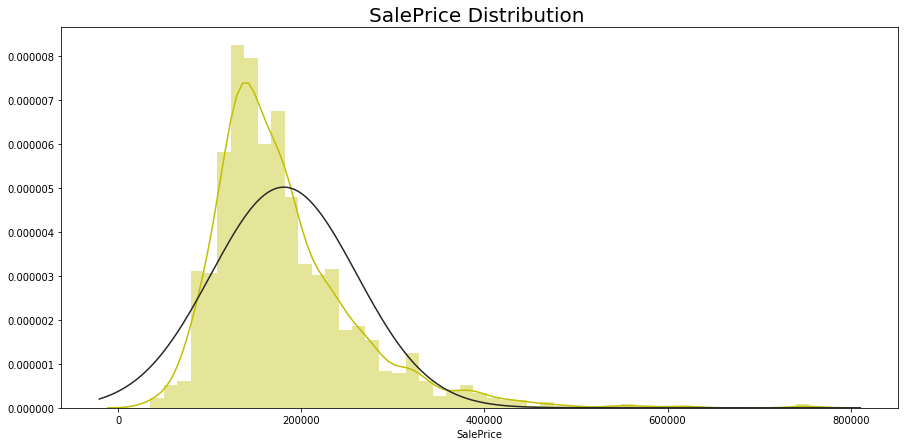

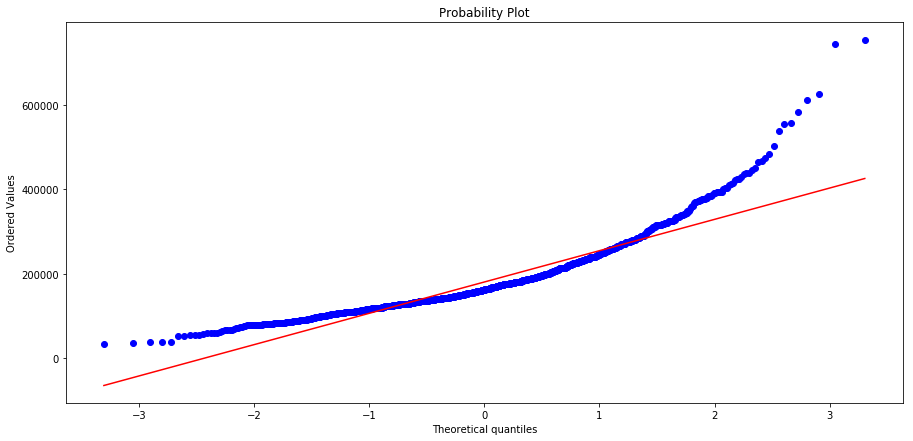

In [10]:
plt.figure(figsize=(15,7))

ax=sns.distplot(df_train['SalePrice'] , fit=norm,color="y")
ax.axes.set_title("SalePrice Distribution ",fontsize=20) 


plt.figure(figsize=(15,7))
res = stats.probplot(df_train['SalePrice'], plot=plt)

The price looks **skewed to the right**. With this I mean that the long tail of the data is on the positive side of the peak.<br>
A **Normal** Distribution **shouldn't be skewed**. So we can conclude that we haven't a Normal Distribution and we also have understood that we might  bring the *columns* of this SalePrice function into the same range.

First we try to fix the skewness of the target variable. As we said, it's left skewed. A good way to improve the skew is to use the log transformation, since it is going always to left skew variables which have a right skew distribution.

In [11]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])


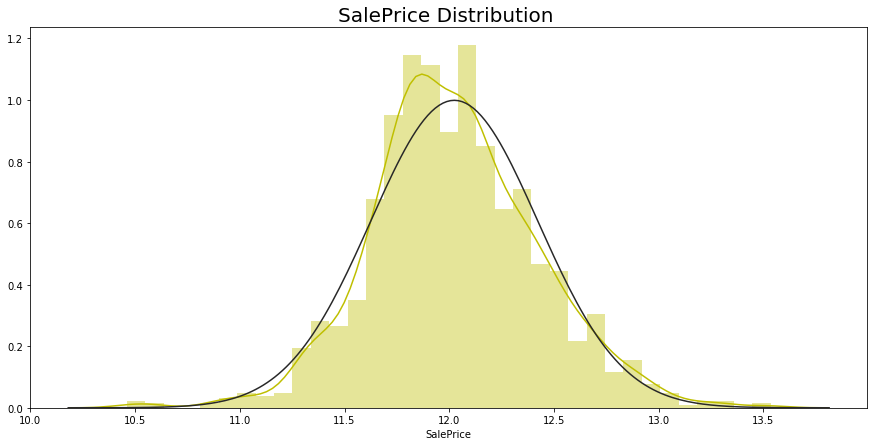

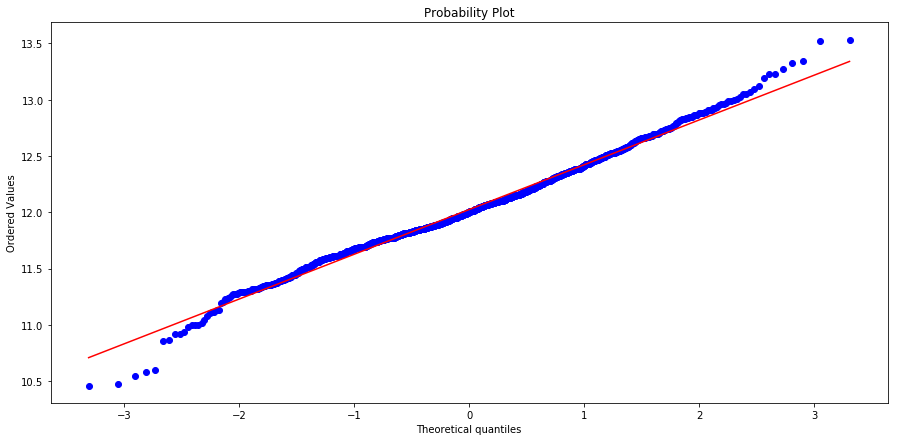

In [12]:
plt.figure(figsize=(15,7))

ax=sns.distplot(df_train['SalePrice'] , fit=norm,color="y");
ax.axes.set_title("SalePrice Distribution ",fontsize=20) 


plt.figure(figsize=(15,7))
res = stats.probplot(df_train['SalePrice'], plot=plt)

If we compare the distribution looking to the previous one, we see now that the skewness is much lower.

In [13]:
skewValue = df_train["SalePrice"].skew()
skewValue

0.12134661989685333

<br>
<br>
Next. Let's see what happens with the other predictors and what info we can get from them...

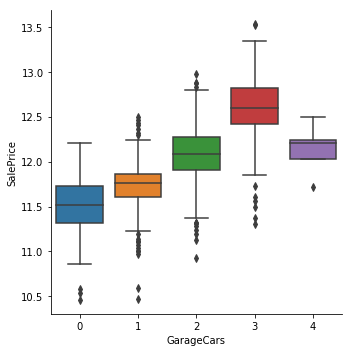

In [14]:
m=sns.catplot(x="GarageCars", y="SalePrice", kind="box", data=df_train)

Normally, when you have space in your garage for 4 cars, you use to pay  more than a garage for 3 cars... Let's see how many houses do we have of this type:

In [15]:
len(df_train.loc[df_train['GarageCars']==4])

5

In [16]:
garage_3cars =df_train.loc[(df_train['GarageCars']==3) & (df_train['SalePrice']>12.3),['OverallQual','GarageCars','GarageArea','GrLivArea','SalePrice']].copy()
garage_3cars

,OverallQual,GarageCars,GarageArea,GrLivArea,SalePrice
4,8,3,836,2198,12.429220
11,9,3,736,2324,12.751303
13,7,3,840,1494,12.540761
20,8,3,853,2376,12.692506
25,8,3,890,1600,12.454108
...,...,...,...,...,...
1403,8,3,754,1464,12.552930
1417,8,3,1069,2450,12.736704
1437,8,3,774,1932,12.885673
1442,10,3,812,2007,12.644331


In [17]:
garage_4cars=df_train.loc[(df_train['GarageCars']==4) & (df_train['SalePrice']<12.4),['OverallQual','GarageCars','GarageArea','GrLivArea','SalePrice']].copy()
garage_4cars

,OverallQual,GarageCars,GarageArea,GrLivArea,SalePrice
420,7,4,784,1344,12.237092
1190,4,4,1356,1622,12.031725
1340,4,4,480,872,11.719948
1350,5,4,968,2634,12.206078


In [18]:
print("Average Quality of a  garage for 4 cars: "+ str(garage_4cars['OverallQual'].mean()))
print("Average Quality of a  garage for 3 cars: "+ str(round(garage_3cars['OverallQual'].mean(),2)))

Average Quality of a  garage for 4 cars: 5.0
Average Quality of a  garage for 3 cars: 8.23


Well now we see why the  houses with garages for 3 cars were cheaper. The quality of this houses could be a reason, it's really poor.
<br>
<br>
If we look now to the `OverallQuality` representation versus the SalePrice we se that there are som outliers in the category of `OverallQuality` = 4.

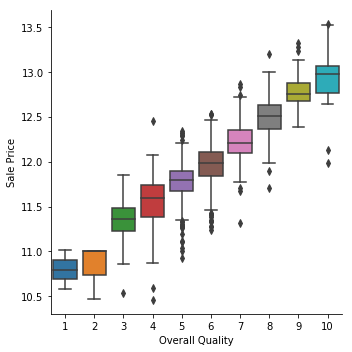

In [19]:
ax = sns.catplot(x="OverallQual", y="SalePrice", kind="box", data=df_train)
ax.set(xlabel='Overall Quality', ylabel='Sale Price')

We could drop some index from the dataset that look outliers in this last figure. The price is really high for a 4 quality.

In [20]:
outliers=  df_train.loc[(df_train['OverallQual'] <5 )&(df_train['SalePrice']>12.3),['OverallQual','SalePrice']]
outliers

,OverallQual,SalePrice
457,4,12.452937


In [21]:
df_train.drop(outliers.index,inplace = True)

This plot does make sense. Because, usually, when higher quality in the materials of the house, (for example: the type of wood used or the use of materials such as marble or gold) the high the price is.<br>

<br>
<br>
<br>
We can focus now in the `GarageArea` Category and  compare it with the `SalePrice`. There is a linear relationship between them as we will see in the next plot. If we include also the `GarageCars`category with the colors, we can see that the relationship is similar...

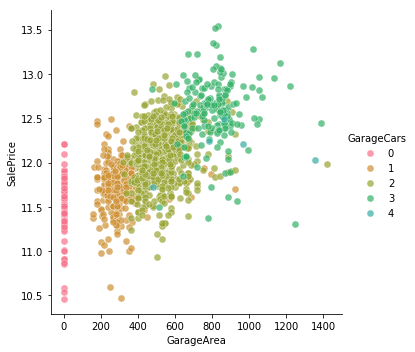

In [22]:
pal = sns.color_palette("husl", 8)
g = sns.FacetGrid(df_train, hue="GarageCars", palette=pal, height=5)
g.map(plt.scatter, "GarageArea", "SalePrice", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend();

As we can see in the picture above, the linear relation between both `SalePrice`,`GrLiveArea` and `GrLivArea`is significant. Could we say say also that the GarageCars are divided between a longer range of price thant the other type of `garageCars`? Looks like!

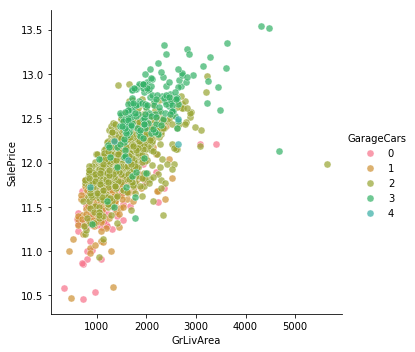

In [23]:
pal = sns.color_palette("husl", 8)
g = sns.FacetGrid(df_train, hue="GarageCars", palette=pal, height=5)
g.map(plt.scatter, "GrLivArea", "SalePrice", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend();

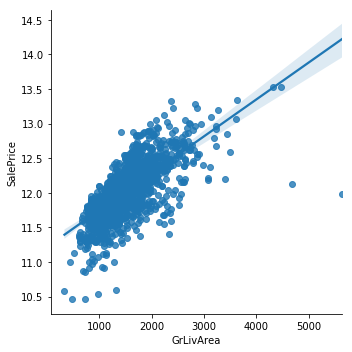

In [24]:
g = sns.FacetGrid(df_train, palette=pal, height=5)
g.map(sns.regplot,"GrLivArea", "SalePrice")


When comparing the `GrLiveArea`we see this two right lower points that don´t make sense. They contain a high `GrLivArea` and a really low `SalePrice`. We can delete them because they are really afecting this linear relation( This is called **outliers**).

First, before dismiss anything, we have to find where are this rows:

Looks like the rows contain values of `GrLivArea` greater than 45000<br>
On the other hand, this rows contain values of `SalePrice` between 11.5 and 13:

In [25]:
outliers=  df_train.loc[(df_train['GrLivArea'] > 4500 )&(df_train['SalePrice']<13)&(df_train['SalePrice']>11.5),['GrLivArea','SalePrice'] ]
outliers

,GrLivArea,SalePrice
523,4676,12.126764
1298,5642,11.982935


In [26]:
df_train.drop(outliers.index, inplace = True)
df_train.reset_index(drop = True)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072547
1453,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254868
1454,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493133
1455,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864469


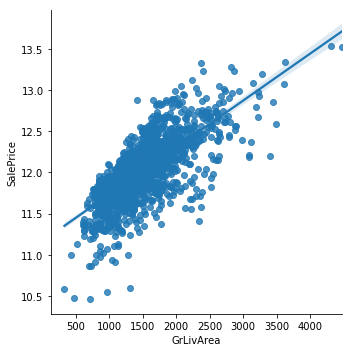

In [27]:
g = sns.FacetGrid(df_train, height=5, palette="GnBu_d")
g.map(sns.regplot,"GrLivArea", "SalePrice")


<br>
<br>
<a id='Feature'></a>

### <span style=" font-family: Palatino Linotype;"><h2><center><u> 3. FEATURE ENGINEERING</u></center></h2></span>

Now we are in the section where most of the modifications over the Dataset will be applied. First of all, we might concatenate both train and test datasets in order to apply the changes over them and not jus ttoi one of them. If we wouldn't do this, the modifications over just one of the Datasets could make some problems in the future. Actually all the Dataset( train + test) should be treated as if it were one.

In [28]:
print( "Train shape before:" + str(df_train.shape))
print( "Test shape before:" + str(df_test.shape))

#We dont need the Id column 
df_train.drop("Id", axis = 1, inplace = True)
y_train = df_train['SalePrice']
df_train.drop(['SalePrice'], axis=1, inplace=True)
df_test.drop("Id", axis = 1, inplace = True)

print("-----------------------------------")
print( "Train shape after:" + str(df_train.shape))
print( "Test shape after:" + str(df_test.shape))



Train shape before:(1457, 81)
Test shape before:(1459, 80)
-----------------------------------
Train shape after:(1457, 79)
Test shape after:(1459, 79)


In [29]:
dim_train = df_train.shape[0]

df_all = pd.concat((df_train,df_test)).reset_index(drop=True)

So now we can start doing some modifications here, there, wherever we need it.<br>

<a id='Missing'></a>
### <span style=" font-family: Palatino Linotype;"><h3><u>3.1. Missing data</u></h3></span>

As we commented before, the task of fixing the Dataset  is really important in the sense of filling in the `Nan`, empty, infinite or wrong values.<br>
On the one hand we are going to fill in the missing values, in case there were, in `SalePrice`. The mode is an appropiate way to do it, since there is just one missing value, there is no other clue in the documentation and both mean and median don`t make sense.

In [30]:
df_all['SaleType'].isna().sum()

1

In [31]:
df_all['SaleType'] = df_all['SaleType'].fillna(df_all['SaleType'].mode()[0])

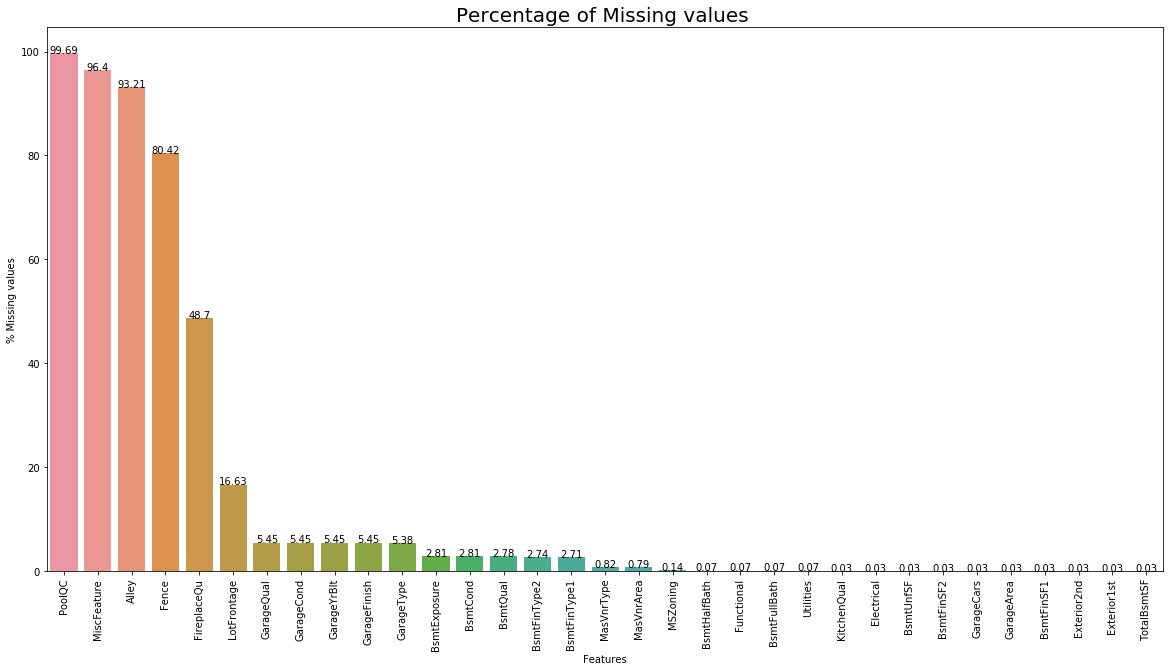

In [32]:
no_rows = len(df_all.index)
nameVar = []
missing_val = []
for var in df_all.columns:
    missing_per = round(((df_all[var].isna().sum())/no_rows)*100,2)
    if (missing_per) > 0:
        nameVar.append(var)
        missing_val.append(missing_per)

df_missVar= pd.DataFrame({'Variables':nameVar,'Percentage Missing':missing_val})
df_missVar = df_missVar.sort_values(by='Percentage Missing', ascending = False)

if(len(df_missVar.values) >= 1):
    plt.figure(figsize=(20,10))
    b = sns.barplot(x = df_missVar['Variables'],
                    y=df_missVar['Percentage Missing'])
    b.axes.set_title("Percentage of Missing values ",fontsize=20) 
    b.set_xlabel("Features",fontsize=10)
    b.set_ylabel("% Missing values",fontsize=10)
    b.tick_params(axis = 'x',labelsize=10,rotation=90)
    b.tick_params(axis = 'y',labelsize=10)
    
    missing_values=df_missVar['Percentage Missing'].values
    for i,index in enumerate(missing_values):
        b.text(i,index, str(round(index,4)), color='black', ha="center",fontsize=10)

#### PoolQC, Alley, Fence and MiscFeature

More than one variable has a high percentage os missing values.One of them is `PoolQC`, which reaches a 99,69% of missing values. That means a lot.<br>
However as the description says, `PoolQC` 's NA values mean **"No Pool"**. In this case, this completely makes sense and we should keep this variable by now. <br><br>
The same happens with the variables `Fence`, `MiscFeature` and `Alley` .Their `NA` values mean: **"no fence"**, **"no misc feature"** and **"no alley access"** in that order.<br>


In [33]:
df_all['PoolQC'] = df_all['PoolQC'].fillna('None')
df_all['Alley'] = df_all['Alley'].fillna('None')
df_all['Fence'] = df_all['Fence'].fillna('None')
df_all['MiscFeature'] = df_all['MiscFeature'].fillna('None')

What should we do with the rest of features missing values?
- `LotFrontage`  
- `MasVnrType `  
- `MasVnrArea ` 
- `BsmtQual   `  
- `BsmtCond   ` 
- `BsmtExposur`    
- `BsmtFinType1`   
- `BsmtFinType2`   
- `Electrical ` 
- `FireplaceQu` 
- `GarageType ` 
- `GarageYrBlt` 
- `GarageFinis`  
- `GarageQual ` 
- `GarageCond ` 

#### LotFrontage

As we can read in the description, this variable mean the `Linear feet of street connected to the house`. <br>The houses are clustered in different neighborhoods ( column `Neighborhood`). So in case we are missing many values here, we could perhaps take the **median** to use the central value of the distribution of values **for every neighborhood**.

In [34]:
df_all['LotFrontage'] = df_all.groupby(
    'Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

#### MasVnrType

`MasVnrType`'s Na value is pretended to mean `None` type of masonry veneer.<br>

In [35]:
df_all['MasVnrType'] = df_all['MasVnrType'].fillna('None')

#### GarageType, GarageFinish, GarageQual, GarageYrBlt  and  GarageCond

In case of the `GarageYrBlt`, there is nothing specified in the description for the missing values meaning. In this case we can see if this missing values are also missing in the other garage variables:

In [36]:
print("There are : " +str(df_all['GarageYrBlt'].notna().sum()) + ' GarageYrBlt missing values')

There are : 2757 GarageYrBlt missing values


In [37]:
print( str(round((df_all['GarageYrBlt'].isna().sum()/len(df_all['GarageYrBlt'])*100), 2)) + "% of missing values")

5.45% of missing values


Maybe take the information from the other`Garage`features in the same range of missing data can bring some light into the problem

In [38]:
df_all.loc[df_all['GarageYrBlt'].isna(),['GarageYrBlt','GarageType','GarageCond','GarageFinish','GarageQual']]

,GarageYrBlt,GarageType,GarageCond,GarageFinish,GarageQual
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2890,NaN,NaN,NaN,NaN,NaN
2906,NaN,NaN,NaN,NaN,NaN
2910,NaN,NaN,NaN,NaN,NaN
2911,NaN,NaN,NaN,NaN,NaN


The missing values from the other "garage columns" match with our variable , so it makes sense, because when there is no garage, we shouldn't have this data. 

In [39]:
df_all['GarageYrBlt']=  df_all['GarageYrBlt'].fillna(0)

`GarageFinish`,`GarageQual`,`GarageCond`,`GarageType`'s Na value is pretended to mean `No Garage`.<br>

In [40]:
df_all['GarageType'] = df_all['GarageType'].fillna('None')
df_all['GarageQual'] = df_all['GarageQual'].fillna('None')
df_all['GarageCond'] = df_all['GarageCond'] .fillna('None')
df_all['GarageFinish'] = df_all['GarageFinish'].fillna('None')

#### MasVnrArea

No clue about the meaning of the missing values of this variable in the description.We could fill this with an area of 0.

In [41]:
df_all['MasVnrArea'].isna().sum()

23

In [42]:
df_all.loc[df_all['MasVnrArea'].isna(),['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,None
527,NaN,None
648,NaN,None
934,NaN,None
971,NaN,None
975,NaN,None
1241,NaN,None
1276,NaN,None
1688,NaN,None
1703,NaN,None


We agree that this missing values are affected by the variable `MasVnrType`. So we can fill the values of the are with `0`.

In [43]:
df_all['MasVnrArea']=df_all['MasVnrArea'].fillna(0)

#### BsmtFinType1, BsmtFinType2, BsmtQual, BsmtExposure, BsmtCond,

`BsmtFinType1`, `BsmtQual`, `BsmtFinType2`, `BsmtCond` and `BsmtExposur`'s Na value is pretended to mean `No Basement` type.<br>

In [44]:
df_all['BsmtFinType1'] = df_all['BsmtFinType1'].fillna('None')
df_all['BsmtFinType2'] = df_all['BsmtFinType2'].fillna('None')
df_all['BsmtQual']     = df_all['BsmtQual'].fillna('None')
df_all['BsmtCond']     = df_all['BsmtCond'].fillna('None')
df_all['BsmtExposure'] = df_all['BsmtExposure'].fillna('None')

#### Electrical

There is nothing written in the description about the missing values of this feature. Let's investigate a bit more about this value.

In [45]:
df_all['Electrical'].isna().sum()

1

Only one missing value.The distribution of the values can maybe help:

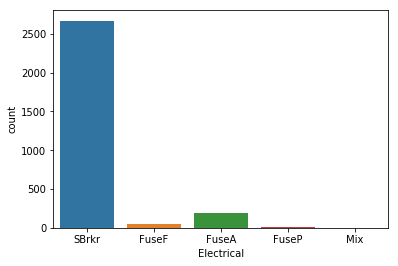

In [46]:
sns.countplot(df_all['Electrical'])

According to the figure, we can fill in the missing value of `Electrical`, with the most predominant value, `SBrkr`.

In [47]:
df_all['Electrical'] = df_all['Electrical'].fillna('SBrkr')

#### FireplaceQu

In this case, the missing value represents `No Fireplace`

In [48]:
df_all['FireplaceQu'] = df_all['FireplaceQu'].fillna('None')

<br>
<br>
<br>


#### MSZoning
Its missing values are not specified in the description, so we could have a look to ths distribution of its values:

In [49]:
df_all['MSZoning'].isna().sum()

4

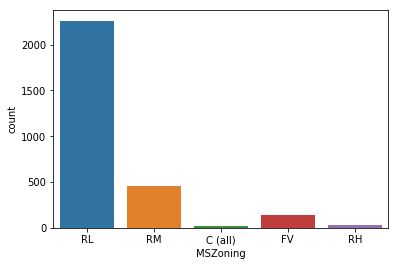

In [50]:
sns.countplot(df_all['MSZoning'])

The most part of the values belong to RL type, we will put the four missing values also in this class.

In [51]:
df_all['MSZoning'] = df_all['MSZoning'].fillna(df_all['MSZoning'].mode()[0])

<br>
<br>
<br>

#### Functional

This feature also has no description. Let's see if the values can tell us something useful:

In [52]:
df_all['Functional'].isna().sum()

2

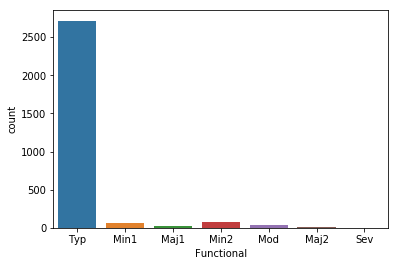

In [53]:
sns.countplot(df_all['Functional'])

So, we could add a `Typ`value to the missing ones.

In [54]:
df_all['Functional'] = df_all['Functional'].fillna('Typ')

<br>
<br>
<br>

#### Utilities

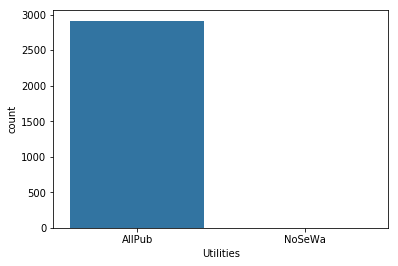

In [55]:
sns.countplot(df_all['Utilities'])

In [56]:
df_all['Utilities'].describe()

count       2914
unique         2
top       AllPub
freq        2913
Name: Utilities, dtype: object

In [57]:
len(df_all.loc[df_all['Utilities'] == 'NoSeWa'])

1

Since there is no description for the missing values in the description and most of the values ( only one is `NoSeWa`) are  `AllPub`. We can delete this feature

In [58]:
df_all.drop('Utilities',axis=1,inplace=True) 

<br>
<br>

#### SaleType
With `SaleType`happens something similar, so we will fill in with `WD`:

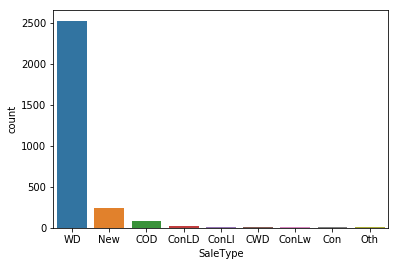

In [59]:
sns.countplot(df_all['SaleType'])

In [60]:
df_all['SaleType'] = df_all['SaleType'].fillna(df_all['SaleType'].mode()[0])

<br>
<br>
<br>

#### KitchenQual
`KitchenQual` has no description for the missing values. Let's see the values distribution:

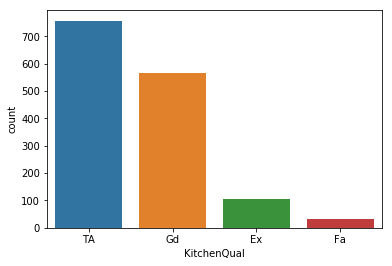

In [61]:
sns.countplot(df_test['KitchenQual'])

In [62]:
df_all['KitchenQual'].isna().sum()

1

Just one missing value???! Let's use the `mode` to fill it

In [63]:
df_all['KitchenQual'] = df_all['KitchenQual'].fillna(df_all['KitchenQual'].mode()[0])

<br>
<br>



#### GarageCars and GarageArea
`GarageCars` missing values mean that there are `0` cars:

In [64]:
df_all['GarageCars'] = df_all['GarageCars'].fillna(0)
df_all['GarageArea'] = df_all['GarageArea'].fillna(0)

<br>
<br>

#### Basement features
`BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `BsmtFullBath`,`BsmtHalfBath` and `TotalBsmtSF`(new feature combined) features which have missing values, could be filled with `0` because the missing values could mean that there is no basement in the house.

In [65]:
bsmt_vars = ['BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'BsmtFullBath','BsmtHalfBath','TotalBsmtSF']
for var in bsmt_vars:
    df_all[var]  = df_all[var].fillna(0)

<br>

#### Exterior features 

 With keep filling with the mode, since there is no indication in the description. Deleting all of this missing value rows could reduce in exccess the test dataframe.`Exterior1st`,`Exterior2nd`.

In [66]:
df_all['Exterior2nd'] = df_all['Exterior2nd'].fillna(df_all['Exterior2nd'].mode()[0])
df_all['Exterior1st'] = df_all['Exterior1st'].fillna(df_all['Exterior1st'].mode()[0])


<br>
<br>

<a id='Types'></a>
### <span style=" font-family: Palatino Linotype;"><h3><u>3.2. Fix Types</u></h3></span>

In our dataset there is just one type which is wrong. The variables `MSSubClass` and  `MoSold`  are categorical features but they are by default assigned as integers.<br>
I'm sure that this two features would like us to change the type to the right one.

In [67]:
some_variables = ['MSSubClass','MoSold']
for var in some_variables:
    print(var + ' has a type ' +str(df_all[var].dtypes))

MSSubClass has a type int64
MoSold has a type int64


In [68]:
for var in some_variables:
    df_all[var]  = df_all[var].apply(str)

On the other hand, there are some features with type `float` when they are really integers:

In [69]:
some_var =['GarageYrBlt','GarageCars','BsmtHalfBath','BsmtFullBath']      
for var in some_var:
    print(var + ' has a type ' +str(df_all[var].dtypes))

GarageYrBlt has a type float64
GarageCars has a type float64
BsmtHalfBath has a type float64
BsmtFullBath has a type float64


In [70]:
for var in some_variables:
    df_all[var]  = df_all[var].apply('int64')

<br>
<br>
<a id='Correlated'></a>

### <span style=" font-family: Palatino Linotype;"><h3><u> 3.3. Correlated variables</u></h3></span>

Well, I was thinking since a long time ago that there are some variables in the dataset that are looking really suspicius...<br>
Yes, I am talking about you, `dear correlated features`:

- `GarageArea` and `GarageCars` are really close each other . When one increase its value, the other one does it also.<br>

One of them could be eliminated depending on the correlation coefficient from the Correlation Matrix that we created in the begining: `GarageArea`. (`GarageArea`: 0,62, `GarageCars`:0,64)

In [71]:
corr= pearsonr(df_train['GarageArea'], df_train['GarageCars'])
corr

(0.8872986058068948, 0.0)

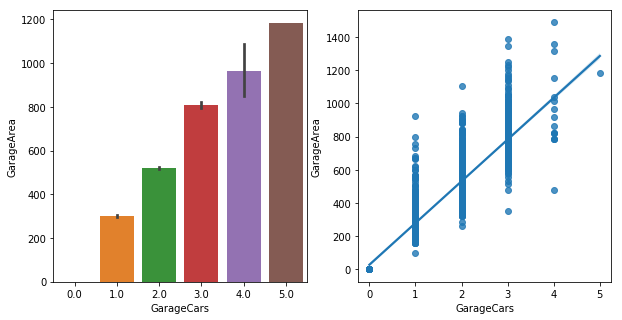

In [72]:
f ,(ax1,ax2)= plt.subplots(1,2,figsize=(10,5))
sns.barplot(x=df_all['GarageCars'], y= df_all['GarageArea'],ax=ax1)
sns.regplot(x="GarageCars", y="GarageArea", data=df_all, ax=ax2);

In [73]:
df_all.drop('GarageArea',axis=1,inplace=True)

Is this all? Could I have a look at out correlation Matrix again please?  (But this time just with our numerical features)

In [74]:
continuous_var =['LotFrontage'   ,'LotArea'    ,'OverallQual'    ,
           'OverallCond'      ,
           'MasVnrArea'   ,'BsmtFinSF1'   ,'BsmtFinSF2'   ,
           'BsmtUnfSF'   ,'TotalBsmtSF'   ,'1stFlrSF'   ,
           '2ndFlrSF'   ,'LowQualFinSF'   ,'GrLivArea'   ,
           'BsmtFullBath','BsmtHalfBath'    ,'FullBath'    ,
           'HalfBath'    ,'BedroomAbvGr'    ,'KitchenAbvGr'    ,
           'TotRmsAbvGrd'    ,'Fireplaces'      ,'GarageYrBlt' ,
           'GarageCars'      ,'WoodDeckSF' ,
           'OpenPorchSF'     ,'EnclosedPorch'   ,'3SsnPorch',
           'ScreenPorch'    ,'PoolArea'        ,'MiscVal'  ,'MoSold'         ,'YrSold']          

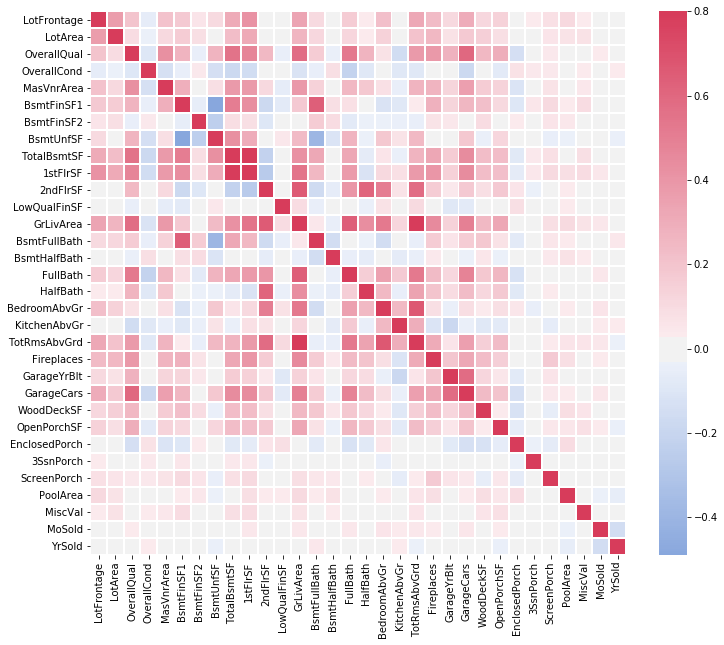

In [75]:
df_continuous = df_all.copy()
df_continuous = df_continuous[continuous_var]

corr_matrix= df_continuous.corr()
f, ax = plt.subplots(figsize=(12,10))
cmap = sns.diverging_palette(255, 5,as_cmap=True)
sns.heatmap(corr_matrix,cmap=cmap,vmax=0.8,center=0, linewidths=.9)

What is this strong correlation between `1stFlrSf` and `TotalBsmtSF`??<br>
And between `TotRmsAbvGrd` and `GrLivArea`?<br>
<br>
- We start with `1stFlrSf` and `TotalBsmtSF`:

In [76]:
corr = pearsonr(df_all['1stFlrSF'], df_all['TotalBsmtSF'])
corr

(0.7932082893249539, 0.0)

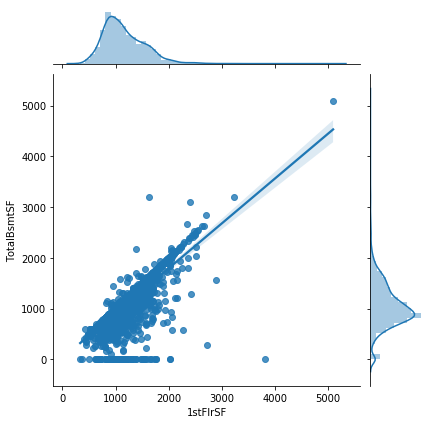

In [77]:
sns.jointplot(x="1stFlrSF", y="TotalBsmtSF", data=df_all, kind="reg");

Let's have a look at the description:<br>
`1stFlrSF`: First Floor square feet<br>
`TotalBsmtSF`: Total square feet of basement area<br>

Instead of deleting one of them, we have another option, combinate them, so in this case we won't lose the knowledge that the hypotetical deleted column could give us.

In [78]:
corr = pearsonr(df_train['1stFlrSF'], y_train)
corr

(0.6201376029415425, 1.4276289857031495e-155)

In [79]:
corr = pearsonr(df_train['TotalBsmtSF'], y_train)
corr

(0.6473910694888642, 7.66197728259065e-174)

In [80]:
#df_all['1st_BsmtSF'] = df_all['1stFlrSF'] + df_all['TotalBsmtSF']
#df_all.drop('1stFlrSF',axis=1,inplace=True)

<a id='Numerical'></a>

### <span style=" font-family: Palatino Linotype;"><h3><u>3.4.  Numerical variables</u></h3></span>

It is important to say that the skewness fixing it correlated with continuous variables, not with categorical.<br>

We are going to fix the skewness of the numerical features now:

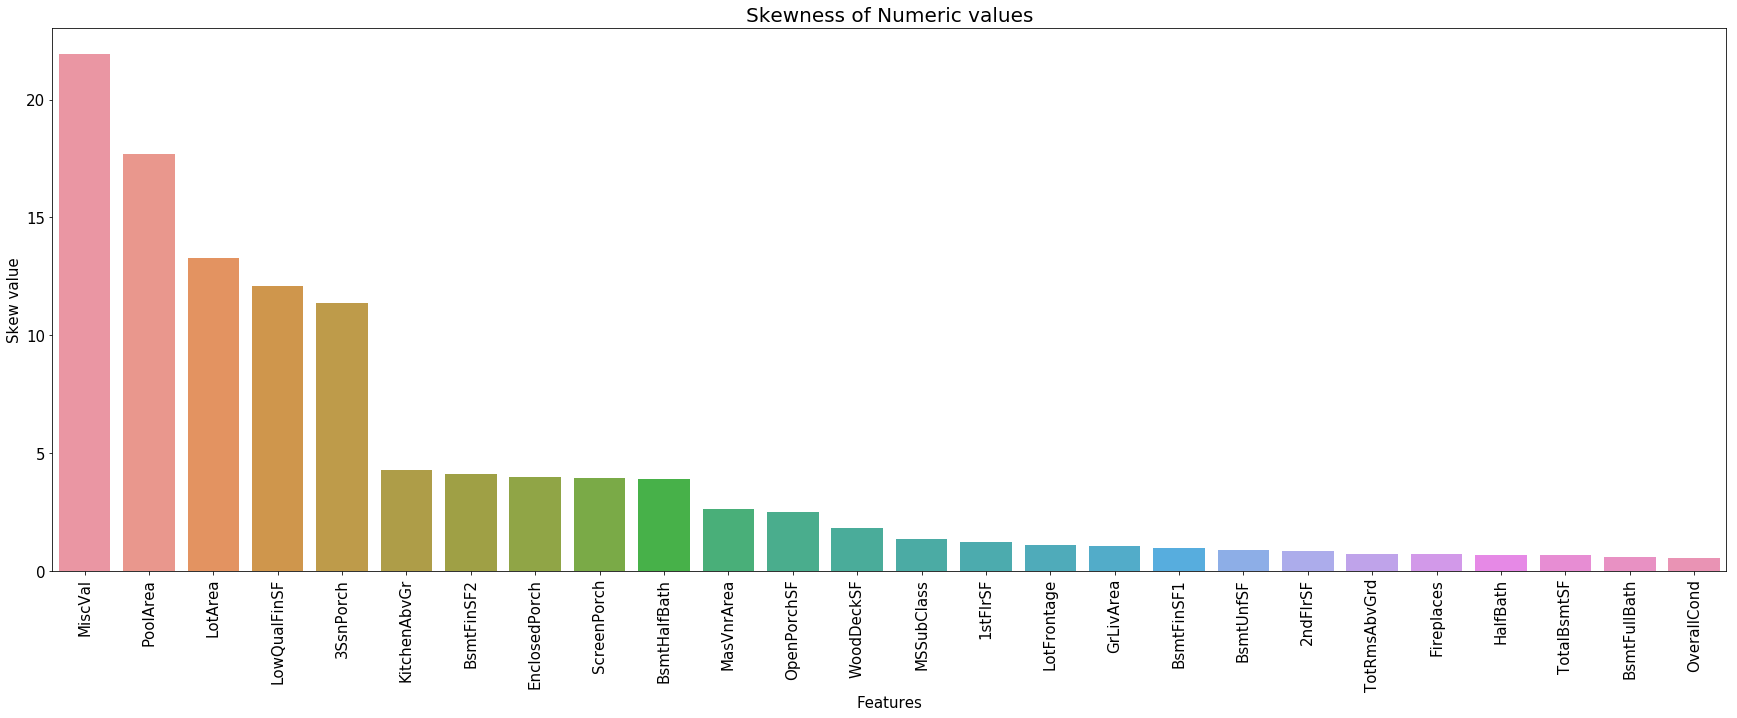

In [81]:
numeric_types = ['int16','int32','int64','float16','float32','float64']
numeric_skew = pd.DataFrame()
numerical_columns  = ['Name','Skew']
data = []
skewed_names = []
for col in df_all.columns:
    if df_all[col].dtypes in numeric_types:
        if (df_all[col].skew()) > 0.5:
            
            skewed_names.append(col)
            values = [col,df_all[col].skew()]
            temp_dic = zip(numerical_columns,values)
            data.append(dict(temp_dic))
numeric_skew = numeric_skew.append(data,ignore_index=False)
numeric_skew = numeric_skew.sort_values(by='Skew',ascending=False)
numeric_skew

plt.figure(figsize=(30,10))
b = sns.barplot(x = numeric_skew['Name'],
                y=numeric_skew['Skew'])
b.axes.set_title("Skewness of Numeric values",fontsize=20)
b.set_xlabel("Features",fontsize=15)
b.set_ylabel("Skew value",fontsize=15)
b.tick_params(axis = 'x',labelsize=15,rotation=90)
b.tick_params(axis = 'y',labelsize=15)


numeric_skewed = df_all[skewed_names].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = numeric_skewed[numeric_skewed > 0.5]

In [82]:
from scipy.stats import boxcox_normmax
skew_index = high_skew.index

for i in skew_index:
    df_all[i] =  boxcox1p(df_all[i],boxcox_normmax(df_all[i] +1 ))

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [83]:
normalized_values = pd.DataFrame({'Skew':df_all[skew_index].skew()}).sort_values(by='Skew', ascending = False)

As it will be shown now in the next figure (`PoolArea`), we still having outliers in our featues. The reason will be explained after the plot of the figure but it's easy to see. Look where are this extreme variables located.

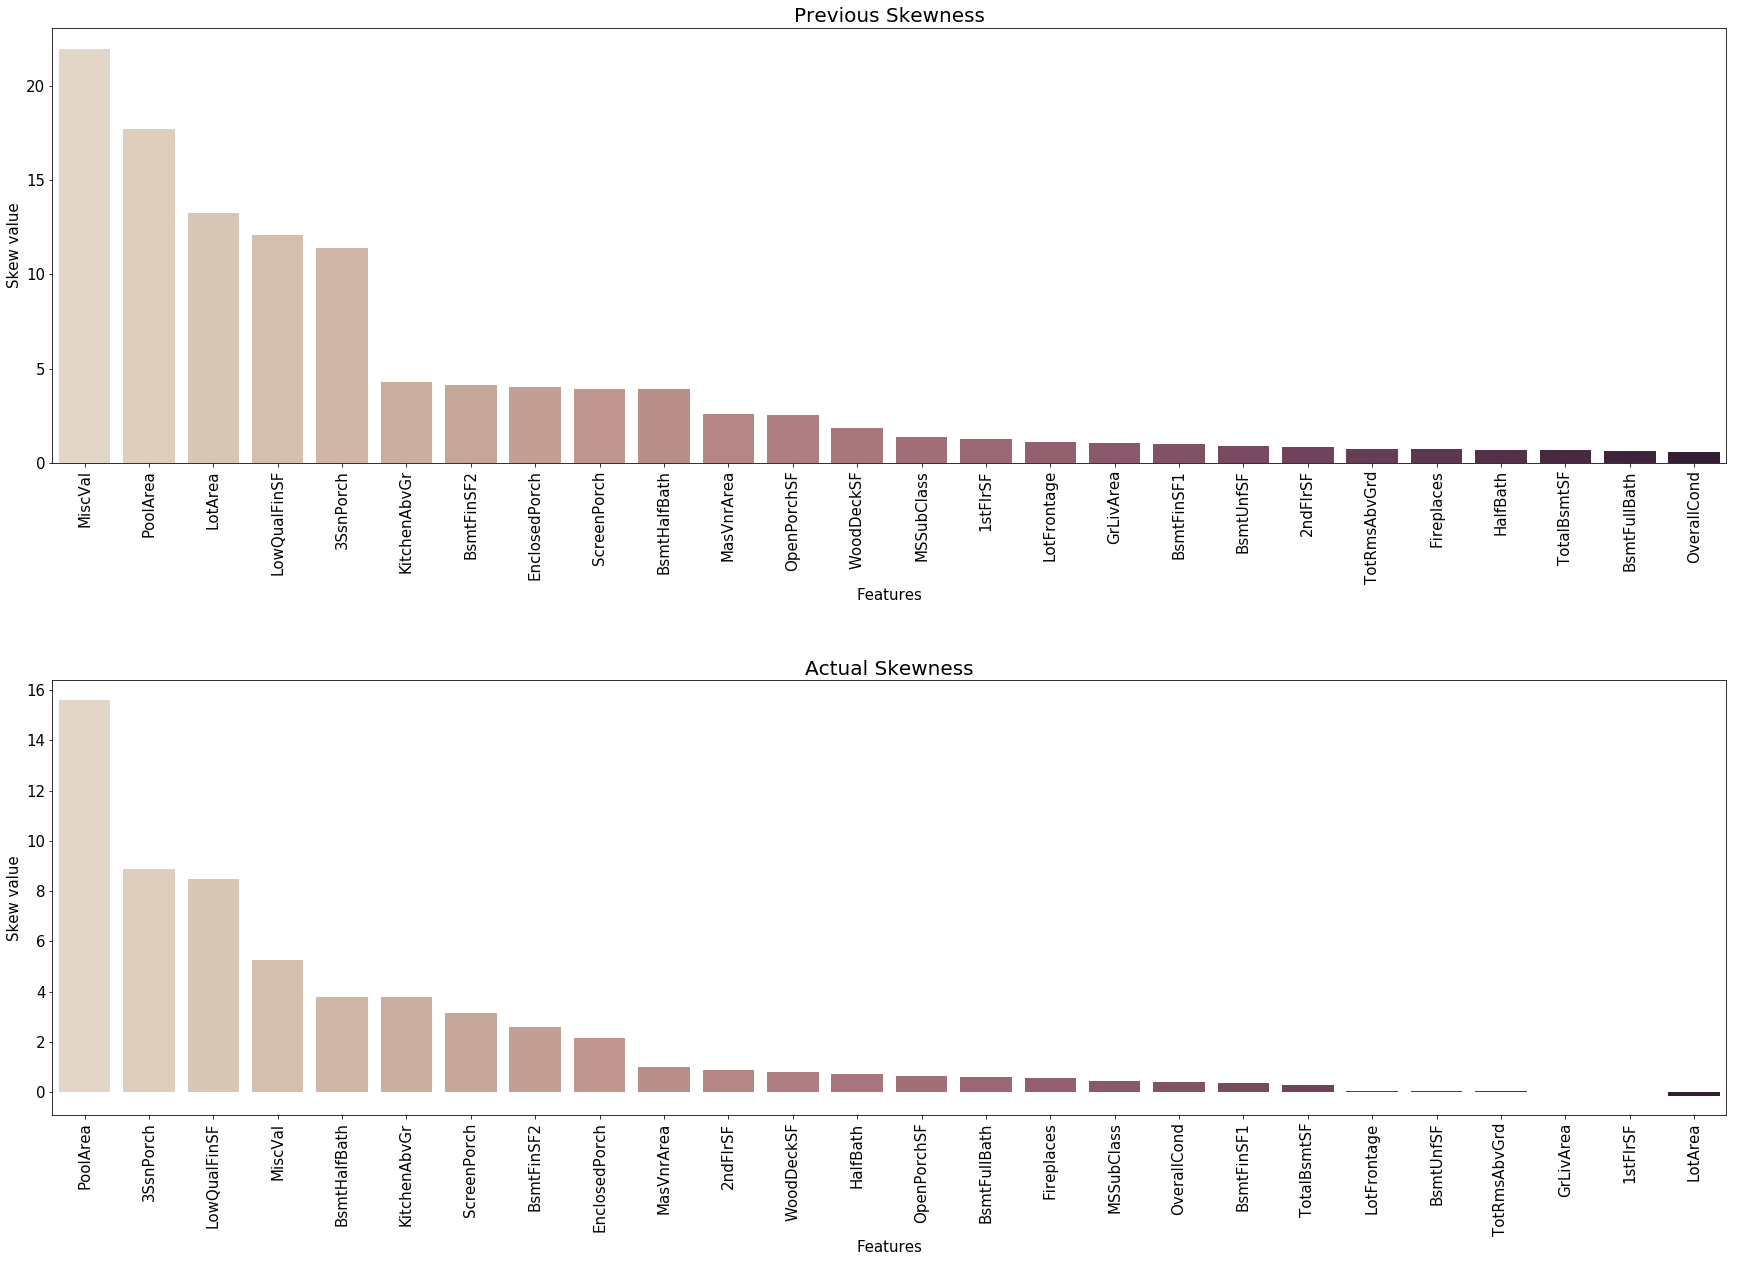

In [84]:
f ,(ax1,ax2)= plt.subplots(2,1,figsize=(30,20) )
plt.subplots_adjust( hspace = 0.5   )
c = sns.barplot(x = numeric_skew['Name'],
                y=numeric_skew['Skew'],palette="ch:.25", ax = ax1)
c.axes.set_title("Previous Skewness",fontsize=20)
c.set_xlabel("Features",fontsize=15)
c.set_ylabel("Skew value",fontsize=15)
c.tick_params(axis = 'x',labelsize=15,rotation=90)
c.tick_params(axis = 'y',labelsize=15)

b = sns.barplot(y = normalized_values.Skew , x = normalized_values.index,palette="ch:.25" , ax = ax2)
b.axes.set_title("Actual Skewness",fontsize=20)
b.set_xlabel("Features",fontsize=15)
b.set_ylabel("Skew value",fontsize=15)
b.tick_params(axis = 'x',labelsize=15,rotation=90)
b.tick_params(axis = 'y',labelsize=15)

In [85]:
#sns.distplot(df_all['PoolArea'] , fit=norm,color="y");

So here we are, with still many skewed variables but as we can see in the previous picture, they are skewed because of the previously filled values ( we filled missing values with `0`). One of the options could be delete this variables but we want to keep this information from now.

<a id='Categorical'></a>

### <span style=" font-family: Palatino Linotype;"><h3><u>3.5. Categorical variables</u></h3></span>

We have a different kind of categorical features in this dataset:
- Ordinal: Follow an order(For example: `HeatingQC`,`BsmtFinType2`,`BsmtExposure`, `BsmtCond`.etc.) 
- Nominal: Doesn't follow an order(For example: `Foundation`,`MasVnrType`, `Exterior2nd`,etc.)

There are different ways to treat this features. In my case, I will use an `conversion to dummies` for both types.

In [86]:
df_all = pd.get_dummies(df_all).reset_index(drop=True)


<a id='Modelling'></a>
### <span style=" font-family: Palatino Linotype;"><h2><center><u> 4. MODELLING & VALIDATION</u></center></h2></span>

There are different ways to procced with the validation, such us: 
`Holdout`, `K-fold` or `Leave-one-out`. In our case I will go on with **K-fold** since it  divides the dataset in *k* groups of same size, the computation time is reduced, also the bias is reduced and every data point get tested just once.

In [87]:
X = df_all.copy()
X = X[:dim_train]
y = y_train.copy()
test = df_all.copy()
test  = test[dim_train:]

In [88]:
kf = KFold(n_splits=5, random_state=42, shuffle=True).get_n_splits(X.values)


<a id='Basic'></a>

### <span style=" font-family: Palatino Linotype;"><h3><u>4.1. Basic Models</u></h3></span>

The next models are the  most widely known modeling techniques. There is also one model (Normal Linear Regression), which is included but just to show the difference of the results comparing it with newer and better techniques.

<a id='svr'></a>
#### 4.1.1. Support Vector Regression
> Unless in simple regression, where the goal is to minimise the error rate, with `SVR`we try to fit the error with a threshold. We try to fit all the data between two boundary lines, separated a `decision boundary` from the hyper plane. It contains a parameter `kernel`that can take different values:
- linear
- polynomial
- rbf
- sigmoid

<a id='ridge'></a>
#### 4.1.2. Ridge
> Similar to `Lasso`but with the difference that in this case, the `beta` coefficients are not so much punished as with `Lasso`, they would become low but not zero. 

<a id='lasso'></a>
#### 4.1.3. Lasso
> Linear model that estimates null coefficients.The regularization term is  in absolute value. It punishes high `beta` coefficients setting them to zero. So you will end with less features in your model than in the beggining.

<a id='elnet'></a>
#### 4.1.4. Elastic-Net
> Linear model that uses both L1 and L2 penalties of the Lasso and Ridge methods.
So, this method improves Lasso's perform with hight-dimensional data. It takes just some of the coefficients as `0` and keeping the regularisation properties of Ridge. 

<a id='ensemble'></a>

### <span style=" font-family: Palatino Linotype;"><h3><u>4.2. Ensemble models</u></h3></span>
Here we take the different predictions coming from different estimators ('weak learners') and combine them to get better results than using them indepently. We have different types ( only the ones that will be used are here introduced) :

- Boosting methods
> Combining models to produce a more powerful model. It is done by building estimators to boost the others by reducing the bias of the combines estimators. The main idea here is to build the ensemble model with a weighted sum of weak learners

- Stacking
> We start with heterogeneous weak learners,it learns them in parallel and finally it combines them by training a meta-model to output a prediction based on the different weak models predictions.
    

<a id='stacking'></a>
####  4.2.1. Stacking Ensembler
>- Comes from SciKit Learn Library.<br>
>- Is generalization of boosting to arbitrary differentiable loss functions. Is accurate and effective off-the-shelf procedure 
>- It uses the calculation of the residuals and  the construction of decision trees minimizing the loss when adding the tress.

<a id='gtb'></a>
#### 4.2.2. Gradient  Boosting

<a id='xgb'></a>
- #### 4.2.2.1. XGBoost
>- Implementation of  gradient boosted decision trees but with improvements of speed and performance.
>- This algorithm also admits sparse features as inputs by learning  the best missing value.

<a id='lgbm'></a>
- ####  4.2.2.2. LightGBM
> Is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
>- Faster training speed and higher efficiency.
>- Lower memory usage.
>- Better accuracy.
>- Support of parallel and GPU learning.
>- Capable of handling large-scale data.
>- LightGBM grows tree vertically while other algorithm grows trees horizontally. Its called *Light* because its really fast. 

<a id='gbr'></a>
- ####  4.2.2.3. Gradient Boosting Regressor
>- Comes from SciKit Learn Library.<br>
>- Is generalization of boosting to arbitrary differentiable loss functions. Is accurate and effective off-the-shelf procedure 
>- It uses the calculation of the residuals and  the construction of decision trees minimizing the loss when adding the tress.

#### RMSE Calculation
The calculation of the metric of interest, Root Mean Squared Error, will be done with the following function. However, the competition's metric is the logaritmic.

In [89]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

<br>
<br>
<br>

#### Basic Linear Regression

In [90]:
lr_rg = LinearRegression()
score_lr = round(rmse_cv(lr_rg).mean(),5)
score_lr_std = round(rmse_cv(lr_rg).std(),5)
print("Linear Regression :", str(score_lr)+ ', std : '+str(score_lr_std))

Linear Regression : 0.12549, std : 0.01417


<br>
<br>

#### SVR

In [91]:
svr_reg = make_pipeline(RobustScaler(), SVR(
    C= 20, epsilon= 0.008, gamma=0.0003))
svr_score = round(rmse_cv(svr_reg).mean(),5)
svr_score_std = round(rmse_cv(svr_reg).std(),5)
print("SVR: "+ str(svr_score) + ', std : '+ str(svr_score_std))

SVR: 0.1104, std : 0.00761


<br>
<br>

#### RIDGE

In [92]:
alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3,4,5, 6, 10, 30, 60]
ridge_reg = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas, cv=kf))
ridge_score = round(rmse_cv(ridge_reg).mean(),5)
ridge_score_std = round(rmse_cv(ridge_reg).std(),5)
print("Ridge: "+ str(ridge_score) + ', std : '+ str(ridge_score_std))

Ridge: 0.1113, std : 0.00605


<br>
<br>

#### LASSO

In [93]:
lasso_reg = make_pipeline(RobustScaler(), LassoCV(alphas=np.arange(0.0001,0.1,0.0001),max_iter = 50000, cv=kf))
lasso_score = round(rmse_cv(lasso_reg).mean(),5)
lasso_score_std = round(rmse_cv(lasso_reg).std(),5)
print("Lasso: "+ str(lasso_score)+ ', std : '+str(lasso_score_std))

Lasso: 0.10842, std : 0.00601


<br>
<br>

#### ELASTIC NET

In [94]:
elnet_reg = make_pipeline(RobustScaler(),ElasticNetCV(
    l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8,0.85, 0.9, 0.95, 1],
    alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                     0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
    max_iter = 50000, cv = kf))

score_elnet = round(rmse_cv(elnet_reg).mean(),5)
score_elnet_std = round(rmse_cv(elnet_reg).std(),5)
print("Elastic Net: "+ str(score_elnet)+ ', std : '+str(score_elnet_std))


Elastic Net: 0.10833, std : 0.00614


<br>
<br>

#### XGBOOST

In [95]:
# Choosing the right parameters took a looooong time with Grid method... Here is the one that best worked for me.
xgb_reg = xgboost.XGBRegressor(
        colsample_bytree=0.4580, gamma=0.05, reg_alpha=0.5, reg_lambda=0.8,
        subsample=0.55, silent=1,learning_rate=0.07, max_depth=3, 
        min_child_weight=1.6, n_estimators=3000,random_state =7,
        nthread = -1)

score_xgb = round(rmse_cv(xgb_reg).mean(),5)
score_xgb_std = round(rmse_cv(xgb_reg).std(),5)
print("XGBoost: "+ str(score_xgb)+ ', std : '+ str(score_xgb_std))

XGBoost: 0.11532, std : 0.00566


<br>
<br>

#### LightGBM

In [96]:
lgbm_reg = lgbm.LGBMRegressor(objective='regression',num_leaves=6,
            feature_fraction_seed=9, bagging_seed=9,learning_rate=0.05,
            n_estimators=790,bagging_fraction = 0.9,max_bin = 52,
            feature_fraction = 0.2340, bagging_freq = 5,min_data_in_leaf =7,
             min_sum_hessian_in_leaf = 12)
score_lgbm= round(rmse_cv(lgbm_reg).mean(),5)
score_lgbm_std= round(rmse_cv(lgbm_reg).std(),5)
print("LightGBM: "+ str(score_lgbm)+ ', std : '+str(score_lgbm_std))

LightGBM: 0.11669, std : 0.00715


<br>
<br>

#### GRADIENT BOOST REGRESSOR

In [97]:
gbr_reg = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score_gbr= round(rmse_cv(gbr_reg).mean(),5)
score_gbr_std= round(rmse_cv(gbr_reg).std(),5)
print("GBR: "+ str(score_gbr)+ ', std : '+str(score_gbr_std))

GBR: 0.11692, std : 0.00675


<br>
<br>

#### STACKING ENSEMBLER

We will ensemble some of our models here: Lasso, SVR and Ridge. Finally we will include a RandomForest.

In [98]:
estimators = [
     ('Ridge', ridge_reg), ('Lasso',lasso_reg),
     ('svr', svr_reg)
 ]
stk_reg = StackingRegressor(
     estimators=estimators,
     final_estimator=elnet_reg)


In [99]:

regressor_df = pd.DataFrame({
                    'Regressor' : ['Linear Regression','SVR','Ridge',
'Lasso','Elastic Net','XGBoost','LightGBM','Gradient Boost Regressor'],
                     'RMSLE' :[ score_lr, svr_score, ridge_score,
 lasso_score, score_elnet, score_xgb, score_lgbm,score_gbr],
                    'RMSLE deviation':[score_lr_std,svr_score_std,
ridge_score_std,lasso_score_std,score_elnet_std,
score_xgb_std,score_lgbm_std,score_gbr_std]} )

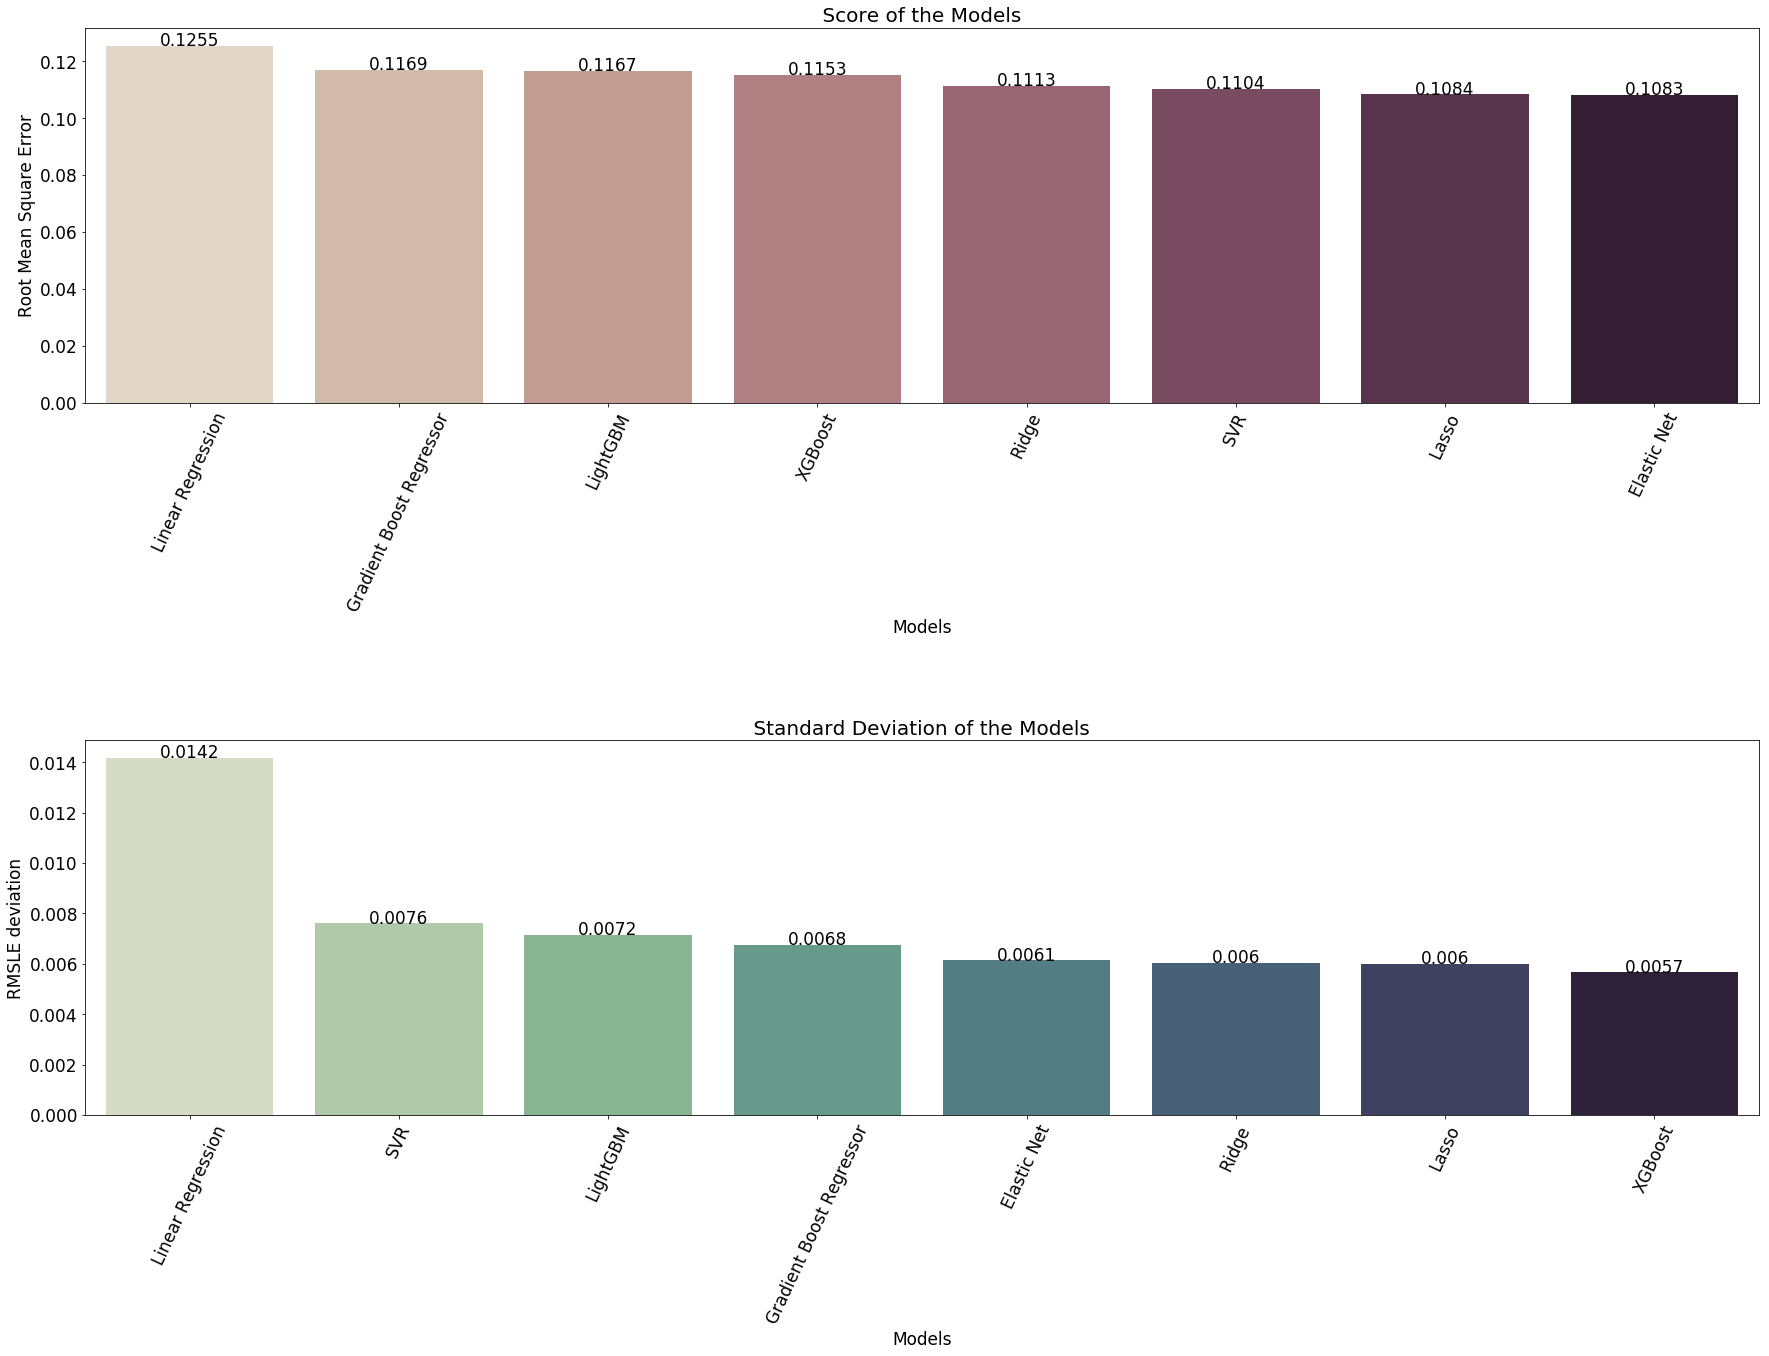

In [100]:
pal = sns.cubehelix_palette(8, start=.5, rot=-.75)
f ,(ax1,ax2)= plt.subplots(2,1,figsize=(30,20) )
plt.subplots_adjust( hspace = 0.9  )

regressor_df = regressor_df.sort_values(by='RMSLE deviation', ascending = False)

c = sns.barplot(x = regressor_df['Regressor'],
                y=regressor_df['RMSLE deviation'],palette=pal,ax=ax2)
c.axes.set_title(" Standard Deviation of the Models ",fontsize=20)
c.set_xlabel("Models",fontsize=17)
c.set_ylabel("RMSLE deviation",fontsize=17)
c.tick_params(axis = 'x',labelsize=17,rotation=65)
c.tick_params(axis = 'y',labelsize=17)

regressor_values=regressor_df['RMSLE deviation'].values
for i,index in enumerate(regressor_values):
    c.text(i,index, round(index,4), color='black', ha="center",fontsize=17)

regressor_df = regressor_df.sort_values(by='RMSLE', ascending = False)
    
b = sns.barplot(x = regressor_df['Regressor'],
                y=regressor_df['RMSLE'],palette="ch:.25", ax=ax1)
b.axes.set_title(" Score of the Models ",fontsize=20)
b.set_xlabel("Models",fontsize=17)
b.set_ylabel("Root Mean Square Error",fontsize=17)
b.tick_params(axis = 'x',labelsize=17,rotation=65)
b.tick_params(axis = 'y',labelsize=17)

regressor_values=regressor_df['RMSLE'].values
for i,index in enumerate(regressor_values):
    b.text(i,index, round(index,4), color='black', ha="center",fontsize=17)

#### Fit Models

In [101]:
# We copy this models for the voting algorithm because we need the unfitted models

lasso_r = lasso_reg
ridge_r = ridge_reg
elnet_r = elnet_reg
svr_r   = svr_reg
lgbm_r   = lgbm_reg

lasso_reg.fit(X,y) # Lasso 
elnet_reg.fit(X,y)  # Elastic Net
ridge_reg.fit(X,y) #Ridge
svr_reg.fit(X,y)   #SVR
lgbm_reg.fit(X,y) #LightGBM

LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.234, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=52,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=7, min_split_gain=0.0,
              min_sum_hessian_in_leaf=12, n_estimators=790, n_jobs=-1,
              num_leaves=6, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

#### Blending models

With blending I mean: constructing an hybrid model with different previous models and using a percentage of the predictive capability of them depending of the score performed before. We will submit finally our results, after predicting the test dataset with this model.

In [102]:


def blended_predictions(x_data):
    return ((0.3 * lasso_reg.predict(x_data)) + (0.2 * elnet_reg.predict(x_data)) + (0.2 * ridge_reg.predict(x_data)) + \
            (0.2 * svr_reg.predict(x_data)) + (0.1 * lgbm_reg.predict(x_data)))
y_pred_blended = np.expm1(blended_predictions(test))


#### Voting Regressor

A voting regressor is an ensemble meta-estimator that fits base regressors each on the whole dataset. It, then, averages the individual predictions to form a final prediction.  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html

In [103]:
from sklearn.ensemble import VotingRegressor
# We need the unfitted models...
vot_reg = VotingRegressor([('stk', stk_reg),('lss', lasso_r),
                      ('rdg', ridge_r),('lnt', elnet_r),
                      ('svr', svr_r), ('lgbm', lgbm_r)])
score_voting= round(rmse_cv(vot_reg).mean(),5)
score_voting_std= round(rmse_cv(vot_reg).std(),5)
print("Voting regressor: "+ str(score_voting)+ ', std : '+str(score_voting_std))
vot_reg.fit(X,y)


Voting regressor: 0.10698, std : 0.00666


VotingRegressor(estimators=[('stk',
                             StackingRegressor(cv=None,
                                               estimators=[('Ridge',
                                                            Pipeline(memory=None,
                                                                     steps=[('robustscaler',
                                                                             RobustScaler(copy=True,
                                                                                          quantile_range=(25.0,
                                                                                                          75.0),
                                                                                          with_centering=True,
                                                                                          with_scaling=True)),
                                                                            ('ridgecv',
                            

<br>
<br>

<a id='Predictions'></a>

### <span style=" font-family: Palatino Linotype;"><h2><center><u>5. PREDICTIONS</u></center></h2></span>

In [104]:
sub_votting = np.expm1(vot_reg.predict(test))
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = sub_votting
sub.to_csv('submission_Votting.csv',index=False)